In [6]:
import SimpleITK as sitk
import numpy as np

CT_data = sitk.ReadImage("transformed_steal_real_v1.nii")
paut = sitk.ReadImage("Edge_Cropped_1.nii")



# Get the size, origin, and spacing for CT_data
CT_size = CT_data.GetSize()
CT_origin = CT_data.GetOrigin()
CT_spacing = CT_data.GetSpacing()

# Get the size, origin, and spacing for paut
paut_size = paut.GetSize()
paut_origin = paut.GetOrigin()
paut_spacing = paut.GetSpacing()

# Print the details
print("CT Data:")
print("Size:", CT_size)
print("Origin:", CT_origin)
print("Spacing:", CT_spacing)

print("\nPAUT Data:")
print("Size:", paut_size)
print("Origin:", paut_origin)
print("Spacing:", paut_spacing)

CT Data:
Size: (1057, 1999, 1057)
Origin: (0.0, 0.0, 0.0)
Spacing: (1.0, 1.0, 1.0)

PAUT Data:
Size: (115, 321, 49)
Origin: (369.09698486328125, 226.04739379882812, 491.5755615234375)
Spacing: (1.2000000476837158, 4.2270002365112305, 7.099999904632568)


In [7]:
def resample_image_to_reference(input_image, reference_image):
    """
    Resample the input_image to match the reference_image's physical space.
    """
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference_image)
    resample.SetInterpolator(sitk.sitkLinear)  # Use linear interpolation
    resample.SetDefaultPixelValue(0)  # Value for out-of-bounds pixels
    resample.SetOutputOrigin(reference_image.GetOrigin())
    resample.SetOutputSpacing(reference_image.GetSpacing())
    resample.SetSize(reference_image.GetSize())
    resample.SetOutputDirection(reference_image.GetDirection())
    return resample.Execute(input_image)

# Resample the PAUT image to match the CT image
resampled_paut = resample_image_to_reference(paut, CT_data)
paut_size = resampled_paut.GetSize()
paut_origin = resampled_paut.GetOrigin()
paut_spacing = resampled_paut.GetSpacing()

print(paut_size)
print(paut_origin)
print(paut_spacing)



(1057, 1999, 1057)
(0.0, 0.0, 0.0)
(1.0, 1.0, 1.0)


In [4]:
import SimpleITK as sitk
import numpy as np
#import pywt
import matplotlib.pyplot as plt

def load_image(file_path):
    """Load a SimpleITK image from file."""
    return sitk.ReadImage(file_path)

def normalize_image(image):
    """Normalize image intensities to range [0,1]."""
    array = sitk.GetArrayFromImage(image)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return sitk.GetImageFromArray(array)

def maximum_fusion(ct_image, paut_image):
    """Apply pixel-wise maximum fusion."""
    return sitk.Maximum(ct_image, paut_image)

def weighted_fusion(ct_image, paut_image, alpha=0.6):
    """Apply weighted averaging fusion: output = alpha * CT + (1-alpha) * PAUT"""
    return sitk.Add(sitk.Multiply(ct_image, alpha), sitk.Multiply(paut_image, (1 - alpha)))

def wavelet_fusion(ct_image, paut_image, wavelet='haar'):
    """Wavelet-based fusion using maximum selection of wavelet coefficients."""
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)

    # Wavelet decomposition
    coeffs_ct = pywt.dwtn(ct_array, wavelet)
    coeffs_paut = pywt.dwtn(paut_array, wavelet)

    # Fusion by maximum selection
    fused_coeffs = {}
    for key in coeffs_ct.keys():
        fused_coeffs[key] = np.maximum(coeffs_ct[key], coeffs_paut[key])

    # Inverse wavelet transform
    fused_array = pywt.idwtn(fused_coeffs, wavelet)
    return sitk.GetImageFromArray(fused_array)

def save_image(image, output_path):
    """Save SimpleITK image to a file."""
    sitk.WriteImage(image, output_path)

def display_fused_image(fused, title='Fused Image', save_path=None):
    """Display the final fused image and optionally save it as PNG."""
    # Get the middle slice of the fused image
    fused_array = sitk.GetArrayFromImage(fused)[fused.GetSize()[2]//2]
    plt.figure(figsize=(5,5))
    plt.imshow(fused_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

def plot_line_profile(image, label, save_path=None):
    """
    Plot line profile (from right to left) for the given image.
    This function extracts the middle row of the middle slice and reverses it.
    Optionally, the figure is saved as a PNG file.
    """
    array = sitk.GetArrayFromImage(image)
    # Get the middle slice
    mid_slice = array[array.shape[0]//2]
    # Get the middle row of that slice
    mid_row = mid_slice[mid_slice.shape[0]//2]
    # Extract the line profile from right to left
    line_profile = mid_row[::-1]

    plt.figure()
    plt.plot(line_profile)
    plt.title(f'Line Profile for {label}')
    plt.xlabel('Pixel (from right to left)')
    plt.ylabel('Intensity')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # Example usage:
    # Assume CT_data and resampled_paut are your input SimpleITK images.
    
    # Normalize images to [0,1]
    ct_image = normalize_image(CT_data)
    paut_image = normalize_image(resampled_paut)

    # Apply fusion techniques
    max_fused = maximum_fusion(ct_image, paut_image)
    weighted_fused = weighted_fusion(ct_image, paut_image, alpha=0.6)
    #wavelet_fused = wavelet_fusion(ct_image, paut_image)

    # Save fused images as NIfTI files
    save_image(max_fused, "max_fused.nii")
    save_image(weighted_fused, "weighted_fused.nii")
    save_image(wavelet_fused, "wavelet_fused.nii")

    # Display only the fused images and save as PNG
    display_fused_image(max_fused, title='Max Fusion', save_path='max_fused.png')
    display_fused_image(weighted_fused, title='Weighted Fusion', save_path='weighted_fused.png')
    display_fused_image(wavelet_fused, title='Wavelet Fusion', save_path='wavelet_fused.png')

    # Plot line profiles for each image and save as PNG files
    plot_line_profile(ct_image, "CT Image", save_path='ct_line_profile.png')
    plot_line_profile(paut_image, "SAFT_NEW_Version", save_path='SAFT_NEW_Version.png')
    plot_line_profile(max_fused, "Max Fused Image", save_path='max_fused_line_profile.png')
    plot_line_profile(weighted_fused, "Weighted Fused Image", save_path='weighted_fused_line_profile.png')
    #plot_line_profile(wavelet_fused, "Wavelet Fused Image", save_path='wavelet_fused_line_profile.png')


RuntimeError: Exception thrown in SimpleITK Maximum: /tmp/SimpleITK/Code/BasicFilters/src/sitkImageFilter.cxx:53:
sitk::ERROR: Input "image2" for "MaximumImageFilter" has pixel type of "32-bit float which does not match the primary input's pixel type of "64-bit float!
The "image2" input may need casting to the "64-bit float" pixel type.

In [9]:
#%pip install PyWavelets
import SimpleITK as sitk
import numpy as np
import pywt  # Make sure you have PyWavelets installed if you want to use wavelet fusion
import matplotlib.pyplot as plt

def load_image(file_path):
    """Load a SimpleITK image from file."""
    return sitk.ReadImage(file_path)

def normalize_image(image):
    """
    Normalize image intensities to the range [0,1].
    Note: We do not cast here yet; we can do the casting after normalization.
    """
    array = sitk.GetArrayFromImage(image)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    out_image = sitk.GetImageFromArray(array)
    # Keep the same spatial metadata (origin, spacing, direction)
    out_image.CopyInformation(image)
    return out_image

def maximum_fusion(ct_image, paut_image):
    """Apply pixel-wise maximum fusion."""
    return sitk.Maximum(ct_image, paut_image)

def weighted_fusion(ct_image, paut_image, alpha=0.6):
    """Apply weighted averaging fusion: output = alpha * CT + (1-alpha) * PAUT."""
    # WeightedFusion = alpha * CT_image + (1 - alpha) * PAUT_image
    return sitk.Add(sitk.Multiply(ct_image, alpha),
                    sitk.Multiply(paut_image, (1.0 - alpha)))

def wavelet_fusion(ct_image, paut_image, wavelet='haar'):
    """
    Wavelet-based fusion using maximum selection of wavelet coefficients.
    Requires 'pywt' (PyWavelets) to be installed.
    """
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)

    # Wavelet decomposition
    coeffs_ct = pywt.dwtn(ct_array, wavelet)
    coeffs_paut = pywt.dwtn(paut_array, wavelet)

    # Fusion by maximum selection of corresponding sub-bands
    fused_coeffs = {}
    for key in coeffs_ct.keys():
        fused_coeffs[key] = np.maximum(coeffs_ct[key], coeffs_paut[key])

    # Inverse wavelet transform
    fused_array = pywt.idwtn(fused_coeffs, wavelet)

    # Convert back to SimpleITK image
    fused_image = sitk.GetImageFromArray(fused_array)
    # Copy spatial metadata from one of the originals (assuming identical size/spacing)
    fused_image.CopyInformation(ct_image)
    return fused_image

def save_image(image, output_path):
    """
    Save SimpleITK image to a file (e.g., .nii, .nrrd, etc.).
    SimpleITK determines format by extension. NIfTI for .nii.
    """
    sitk.WriteImage(image, output_path)

def display_fused_image(fused, title='Fused Image', save_path=None):
    """
    Display the final fused image (middle slice) and optionally save it as a .png.
    """
    # Convert the entire 3D volume to numpy first
    fused_array = sitk.GetArrayFromImage(fused)
    # Select the middle slice along the z-axis
    z_mid = fused_array.shape[0] // 2
    fused_middle_slice = fused_array[z_mid, :, :]

    plt.figure(figsize=(5, 5))
    plt.imshow(fused_middle_slice, cmap='gray')
    plt.title(title)
    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

def plot_line_profile(image, label, save_path=None):
    """
    Plot a line profile (from right to left) of the middle row in the middle slice of the given 3D image.
    Optionally, save the figure as a .png file.
    """
    array = sitk.GetArrayFromImage(image)

    # Get the middle slice along z
    mid_slice_idx = array.shape[0] // 2
    mid_slice = array[mid_slice_idx, :, :]

    # Get the middle row of the slice
    mid_row_idx = mid_slice.shape[0] // 2
    mid_row = mid_slice[mid_row_idx, :]

    # Reverse the row (so we go from right to left)
    line_profile = mid_row[::-1]

    plt.figure()
    plt.plot(line_profile)
    plt.title(f'Line Profile for {label}')
    plt.xlabel('Pixel (from right to left)')
    plt.ylabel('Intensity')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # -----------------------------------------------------------------------
    # Example usage:
    # Replace these paths with your actual image file paths (NIfTI, DICOM, etc.).
    # -----------------------------------------------------------------------


    # Load the images
    CT_data = load_image(CT_data)
    resampled_paut = load_image(resampled_paut)

    # Normalize images to [0,1]
    ct_image = normalize_image(CT_data)
    paut_image = normalize_image(resampled_paut)

    # IMPORTANT: Cast to the same pixel type to avoid mismatch errors
    ct_image = sitk.Cast(ct_image, sitk.sitkFloat32)
    paut_image = sitk.Cast(paut_image, sitk.sitkFloat32)

    # Apply fusion techniques
    max_fused = maximum_fusion(ct_image, paut_image)
    weighted_fused = weighted_fusion(ct_image, paut_image, alpha=0.6)
    wavelet_fused = wavelet_fusion(ct_image, paut_image, wavelet='haar')

    # Save fused images as NIfTI files
    save_image(max_fused, "max_fused.nii")
    save_image(weighted_fused, "weighted_fused.nii")
    save_image(wavelet_fused, "wavelet_fused.nii")

    # Display fused images (middle slice) and save each as PNG
    display_fused_image(max_fused, title='Max Fusion', save_path='max_fused.png')
    display_fused_image(weighted_fused, title='Weighted Fusion', save_path='weighted_fused.png')
    display_fused_image(wavelet_fused, title='Wavelet Fusion', save_path='wavelet_fused.png')

    # Plot line profiles and save as PNG files
    plot_line_profile(ct_image, "CT Image", save_path='ct_line_profile.png')
    plot_line_profile(paut_image, "SAFT_NEW_Version", save_path='SAFT_NEW_Version_line_profile.png')
    plot_line_profile(max_fused, "Max Fused Image", save_path='max_fused_line_profile.png')
    plot_line_profile(weighted_fused, "Weighted Fused Image", save_path='weighted_fused_line_profile.png')
    plot_line_profile(wavelet_fused, "Wavelet Fused Image", save_path='wavelet_fused_line_profile.png')


TypeError: in method 'ImageSeriesReader_SetFileNames', argument 2 of type 'std::vector< itk::simple::PathType,std::allocator< itk::simple::PathType > > const &'

In [10]:
import SimpleITK as sitk
import numpy as np
#import pywt
import matplotlib.pyplot as plt

def load_image(file_path):
    """Load a SimpleITK image from file."""
    return sitk.ReadImage(file_path)

def normalize_image(image):
    """Normalize image intensities to range [0,1]."""
    array = sitk.GetArrayFromImage(image)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return sitk.GetImageFromArray(array)

def cast_to_int(image, pixel_type=sitk.sitkUInt16):
    """Cast image to integer type (UInt16) for compatibility with Mask operations."""
    return sitk.Cast(image, pixel_type)

def extract_middle_slice(image):
    """
    Extract the middle slice from a 3D image using SimpleITK's ExtractImageFilter.
    This returns a 2D image.
    """
    size = list(image.GetSize())
    index = [0, 0, size[2] // 2]
    # Set the size for the extraction: full in x and y, but only 0 in the z-direction.
    size[2] = 0  
    extractor = sitk.ExtractImageFilter()
    extractor.SetSize(size)
    extractor.SetIndex(index)
    return extractor.Execute(image)

# --- Joint Bilateral Filtering ---
def joint_bilateral_filter(ct_image, paut_image, sigma_color=0.05, sigma_space=10):
    """Apply joint bilateral filtering using PAUT as guidance."""
    bilateral_filter = sitk.BilateralImageFilter()
    bilateral_filter.SetDomainSigma(sigma_space)
    bilateral_filter.SetRangeSigma(sigma_color)
    return bilateral_filter.Execute(ct_image)

# --- Multi-Modal Noise Reduction via Fusion ---
def multimodal_fusion_denoising(filtered_ct_image, paut_image):
    """
    Apply wavelet-based noise reduction by fusing PAUT guidance.
    Here, the filtered CT image from the joint bilateral filter is fused with the PAUT slice.
    """
    ct_array = sitk.GetArrayFromImage(filtered_ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)
    
    coeffs_ct = pywt.dwtn(ct_array, 'haar')
    coeffs_paut = pywt.dwtn(paut_array, 'haar')
    fused_coeffs = {key: (coeffs_ct[key] + coeffs_paut[key]) / 2 for key in coeffs_ct.keys()}
    denoised_array = pywt.idwtn(fused_coeffs, 'haar')
    return sitk.GetImageFromArray(denoised_array)

# --- Display Function for Filtered Image ---
def display_filtered_image(filtered, title='Filtered Image', save_path=None):
    """Display only the final filtered image (2D slice) and optionally save as PNG."""
    filtered_array = sitk.GetArrayFromImage(filtered)
    plt.figure(figsize=(5,5))
    plt.imshow(filtered_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

def plot_line_profile(image, label, save_path=None):
    """
    Plot a line profile (from right to left) for the given image.
    This function extracts the middle row and reverses it.
    Optionally, the figure is saved as a PNG file.
    """
    array = sitk.GetArrayFromImage(image)
    # For a 2D image, get the middle row
    mid_row = array[array.shape[0]//2]
    line_profile = mid_row[::-1]  # Right-to-left
    plt.figure()
    plt.plot(line_profile)
    plt.title(f'Line Profile for {label}')
    plt.xlabel('Pixel (from right to left)')
    plt.ylabel('Intensity')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # Assume CT_data and resampled_paut are previously loaded 3D images.
    
    # Normalize full volumes
    ct_normalized = normalize_image(CT_data)
    paut_normalized = normalize_image(resampled_paut)
    
    # Extract middle slice from each volume (2D images)
    ct_slice = extract_middle_slice(ct_normalized)
    paut_slice = extract_middle_slice(paut_normalized)
    
    # Apply joint bilateral filtering first
    bilateral_filtered = joint_bilateral_filter(ct_slice, paut_slice)
    
    # Then apply multi-modal fusion denoising using the bilateral filtered result and PAUT slice
    fusion_filtered = multimodal_fusion_denoising(bilateral_filtered, paut_slice)
    
    # Display final filtered images only and save as PNG
    display_filtered_image(bilateral_filtered, title='Joint Bilateral Filtering', save_path='joint_bilateral_filter.png')
    display_filtered_image(fusion_filtered, title='Multi-Modal Fusion Denoising', save_path='fusion_denoised.png')
    
    # Plot line profiles for original and filtered images and save as PNG files
    plot_line_profile(bilateral_filtered, "Joint Bilateral Filtered CT", save_path='joint_bilateral_line_profile.png')
    plot_line_profile(fusion_filtered, "Fusion Denoised CT", save_path='fusion_denoised_line_profile.png')


NameError: name 'pywt' is not defined

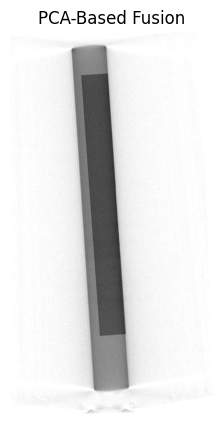

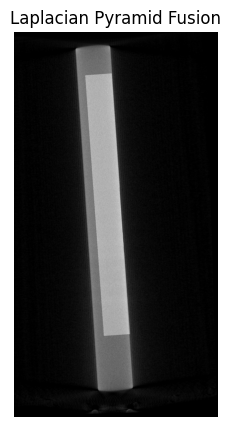

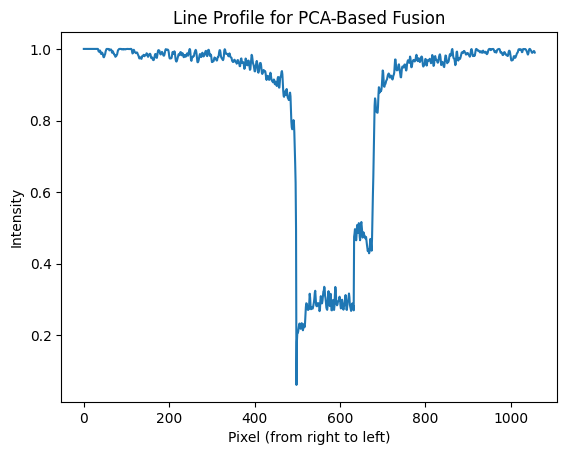

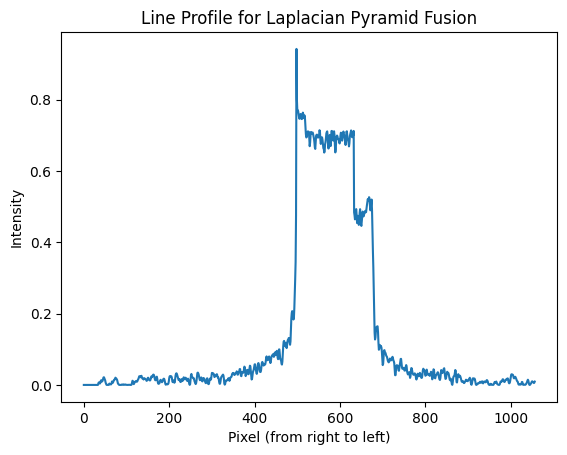

In [3]:
import SimpleITK as sitk
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

def normalize_image(image):
    """Normalize image intensities to range [0,1] and return a SimpleITK image."""
    array = sitk.GetArrayFromImage(image)
    normalized_array = (array - np.min(array)) / (np.max(array) - np.min(array))
    normalized_image = sitk.GetImageFromArray(normalized_array)
    return sitk.Cast(normalized_image, sitk.sitkFloat32)

def extract_middle_slice(image):
    """
    Extract the middle slice from a 3D image using SimpleITK's ExtractImageFilter.
    Returns a 2D SimpleITK image.
    """
    size = list(image.GetSize())
    index = [0, 0, size[2] // 2]
    size[2] = 0  # extract only one slice along the z-direction
    extractor = sitk.ExtractImageFilter()
    extractor.SetSize(size)
    extractor.SetIndex(index)
    return extractor.Execute(image)

def pca_fusion(ct_image, paut_image):
    """
    Fuse two modalities using a PCA-based approach.
    """
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)
    
    pixels = np.stack((ct_array.flatten(), paut_array.flatten()), axis=1)
    mean = np.mean(pixels, axis=0)
    centered = pixels - mean
    cov = np.cov(centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    principal_component = eigvecs[:, np.argmax(eigvals)]
    fused_flat = np.dot(centered, principal_component)
    
    fused_array = fused_flat.reshape(ct_array.shape)
    fused_array = (fused_array - np.min(fused_array)) / (np.max(fused_array) - np.min(fused_array))
    return sitk.GetImageFromArray(fused_array)

def laplacian_pyramid_fusion(ct_image, paut_image, levels=3, sigma=1.0, weight=0.5):
    """
    Fuse two modalities using Laplacian pyramid fusion.
    """
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)

    def gaussian_pyramid(image_array, levels, sigma):
        gp = [image_array]
        for _ in range(1, levels):
            image_array = ndimage.gaussian_filter(image_array, sigma=sigma)
            image_array = image_array[::2, ::2]
            gp.append(image_array)
        return gp

    def laplacian_pyramid(gp):
        lp = []
        for i in range(len(gp) - 1):
            expanded = ndimage.zoom(gp[i + 1], zoom=2, order=1)
            if expanded.shape != gp[i].shape:
                expanded = expanded[:gp[i].shape[0], :gp[i].shape[1]]
            lp.append(gp[i] - expanded)
        lp.append(gp[-1])
        return lp

    def reconstruct_from_laplacian(lp):
        image = lp[-1]
        for l in reversed(lp[:-1]):
            image = ndimage.zoom(image, zoom=2, order=1)
            if image.shape != l.shape:
                image = image[:l.shape[0], :l.shape[1]]
            image = image + l
        return image

    gp_ct = gaussian_pyramid(ct_array, levels, sigma)
    gp_paut = gaussian_pyramid(paut_array, levels, sigma)

    lp_ct = laplacian_pyramid(gp_ct)
    lp_paut = laplacian_pyramid(gp_paut)

    fused_lp = [weight * l_ct + (1 - weight) * l_paut for l_ct, l_paut in zip(lp_ct, lp_paut)]
    
    fused_array = reconstruct_from_laplacian(fused_lp)
    fused_array = (fused_array - np.min(fused_array)) / (np.max(fused_array) - np.min(fused_array))
    return sitk.GetImageFromArray(fused_array)

def display_fused_image(fused, title, save_path=None):
    """Display only the final fused image and optionally save it as PNG."""
    fused_array = sitk.GetArrayFromImage(fused)
    plt.figure(figsize=(5, 5))
    plt.imshow(fused_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

def plot_line_profile(image, label, save_path=None):
    """
    Plot a line profile (from right to left) for the given image.
    """
    array = sitk.GetArrayFromImage(image)
    mid_row = array[array.shape[0] // 2]
    line_profile = mid_row[::-1]

    plt.figure()
    plt.plot(line_profile)
    plt.title(f'Line Profile for {label}')
    plt.xlabel('Pixel (from right to left)')
    plt.ylabel('Intensity')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # Assume CT_data and resampled_paut are pre-loaded 3D SimpleITK images.
    
    # Normalize volumes
    ct_normalized = normalize_image(CT_data)
    paut_normalized = normalize_image(resampled_paut)
    
    # Extract the middle slice from each volume
    ct_slice = extract_middle_slice(ct_normalized)
    paut_slice = extract_middle_slice(paut_normalized)
    
    # Apply fusion methods
    fused_pca = pca_fusion(ct_slice, paut_slice)
    fused_laplacian = laplacian_pyramid_fusion(ct_slice, paut_slice, levels=4, sigma=1.0, weight=0.6)
    
    # Display final fused images and save as PNG
    display_fused_image(fused_pca, title='PCA-Based Fusion', save_path='pca_fusion.png')
    display_fused_image(fused_laplacian, title='Laplacian Pyramid Fusion', save_path='laplacian_fusion.png')

    # Plot line profiles for fused images and save as PNG
    plot_line_profile(fused_pca, "PCA-Based Fusion", save_path='pca_fusion_line_profile.png')
    plot_line_profile(fused_laplacian, "Laplacian Pyramid Fusion", save_path='laplacian_fusion_line_profile.png')


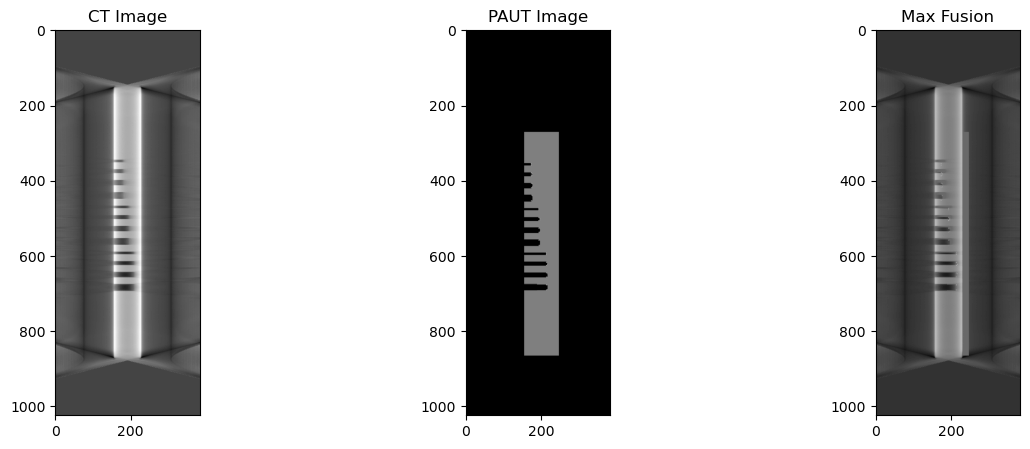

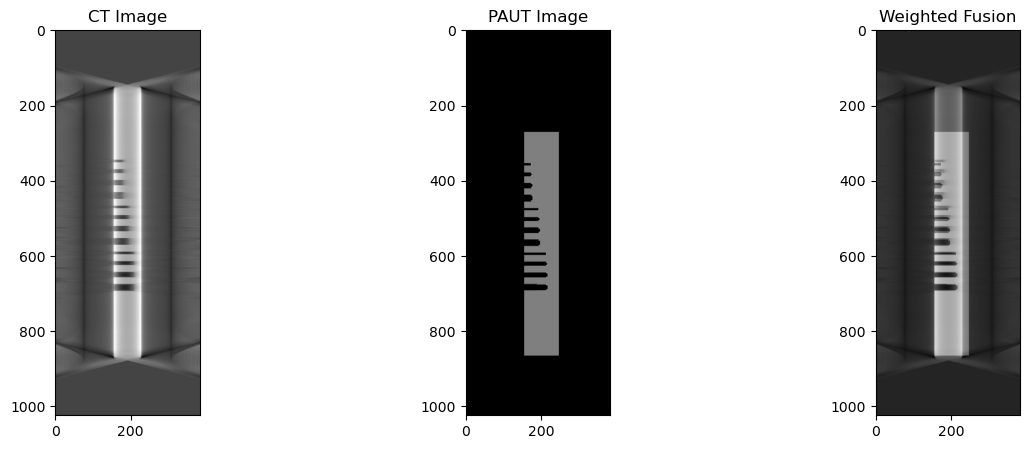

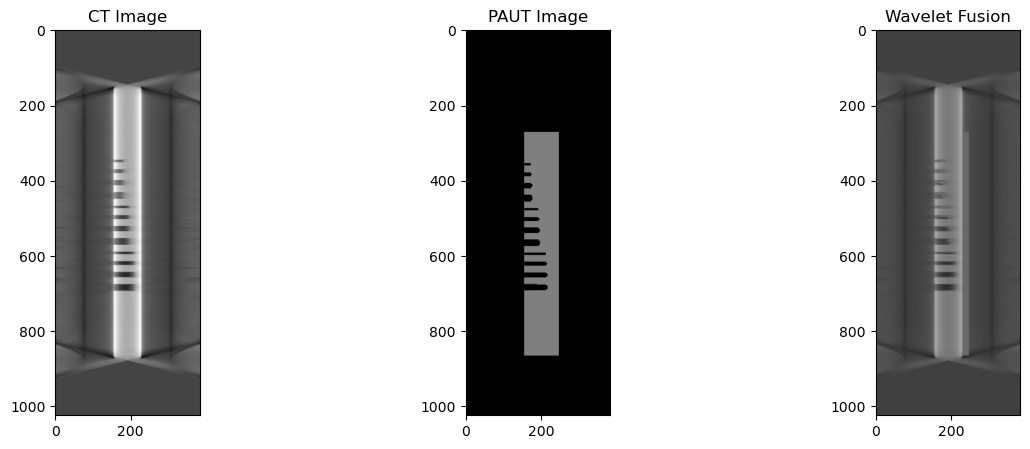

In [61]:
import SimpleITK as sitk
import numpy as np
import pywt
import matplotlib.pyplot as plt

def load_image(file_path):
    """Load a SimpleITK image from file."""
    return sitk.ReadImage(file_path)

def normalize_image(image):
    """Normalize image intensities to range [0,1]."""
    array = sitk.GetArrayFromImage(image)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return sitk.GetImageFromArray(array)

def maximum_fusion(ct_image, paut_image):
    """Apply pixel-wise maximum fusion."""
    return sitk.Maximum(ct_image, paut_image)

def weighted_fusion(ct_image, paut_image, alpha=0.6):
    """Apply weighted averaging fusion: output = alpha * CT + (1-alpha) * PAUT"""
    return sitk.Add(sitk.Multiply(ct_image, alpha), sitk.Multiply(paut_image, (1 - alpha)))

def wavelet_fusion(ct_image, paut_image, wavelet='haar'):
    """Wavelet-based fusion using maximum selection of wavelet coefficients."""
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)
    
    # Wavelet decomposition
    coeffs_ct = pywt.dwtn(ct_array, wavelet)
    coeffs_paut = pywt.dwtn(paut_array, wavelet)
    
    # Fusion by maximum selection
    fused_coeffs = {}
    for key in coeffs_ct.keys():
        fused_coeffs[key] = np.maximum(coeffs_ct[key], coeffs_paut[key])
    
    # Inverse wavelet transform
    fused_array = pywt.idwtn(fused_coeffs, wavelet)
    return sitk.GetImageFromArray(fused_array)

def save_image(image, output_path):
    """Save SimpleITK image to a file."""
    sitk.WriteImage(image, output_path)

def display_images(ct, paut, fused, title='Fused Image'):
    """Display images side by side for comparison."""
    ct_array = sitk.GetArrayFromImage(ct)[ct.GetSize()[2]//2]  # Middle slice
    paut_array = sitk.GetArrayFromImage(paut)[paut.GetSize()[2]//2]
    fused_array = sitk.GetArrayFromImage(fused)[fused.GetSize()[2]//2]
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(ct_array, cmap='gray')
    plt.title('CT Image')
    plt.subplot(1,3,2)
    plt.imshow(paut_array, cmap='gray')
    plt.title('PAUT Image')
    plt.subplot(1,3,3)
    plt.imshow(fused_array, cmap='gray')
    plt.title(title)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Normalize images to [0,1]
    ct_image = normalize_image(CT_data)
    paut_image = normalize_image(resampled_paut)
    
    # Apply fusion techniques
    max_fused = maximum_fusion(ct_image, paut_image)
    weighted_fused = weighted_fusion(ct_image, paut_image, alpha=0.6)
    wavelet_fused = wavelet_fusion(ct_image, paut_image)
    
    # Save results
    save_image(max_fused, "max_fused.nii")
    save_image(weighted_fused, "weighted_fused.nii")
    save_image(wavelet_fused, "wavelet_fused.nii")
    
    # Display results
    display_images(ct_image, paut_image, max_fused, title='Max Fusion')
    display_images(ct_image, paut_image, weighted_fused, title='Weighted Fusion')
    display_images(ct_image, paut_image, wavelet_fused, title='Wavelet Fusion')


MaskImageFilter (0x16b8744a0): Support for pixel type 16-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. MaskImageFilter (0x16b8744a0): Support for pixel type 16-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. MaskImageFilter (0x16b8744a0): Support for pixel type 16-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. 

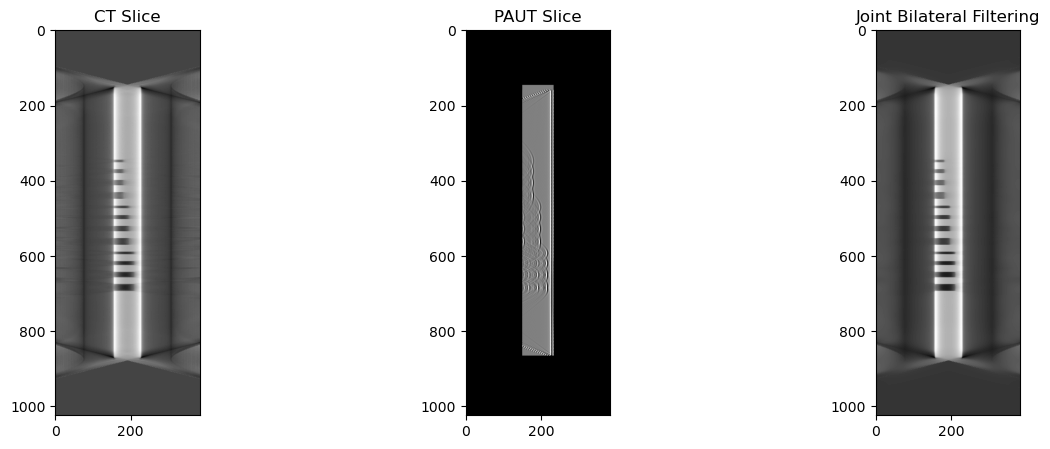

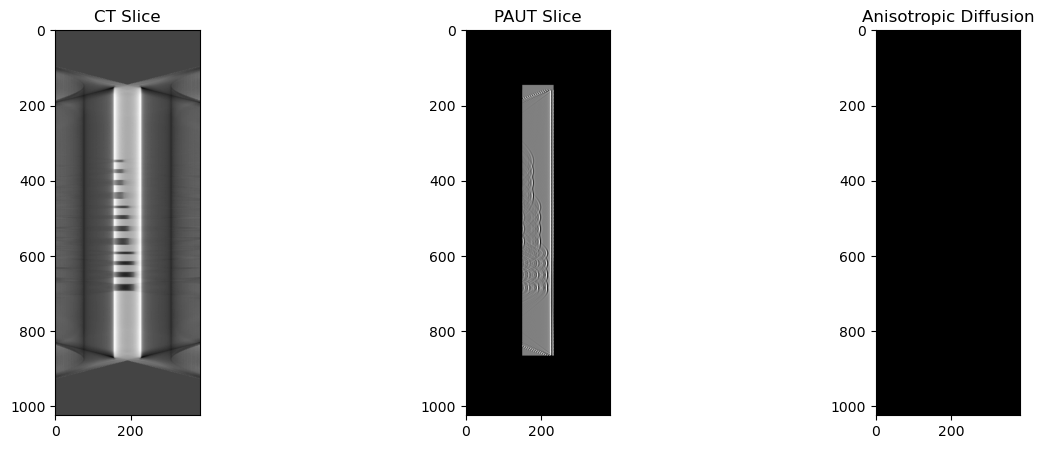

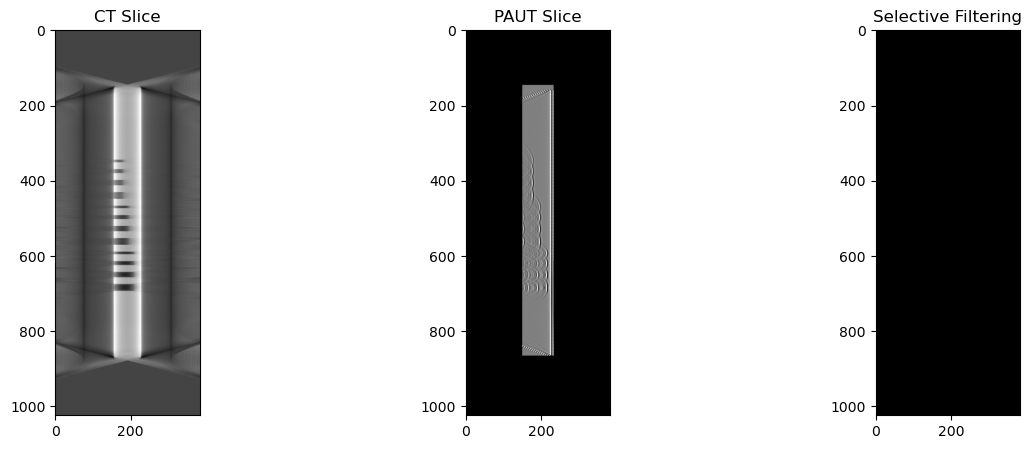

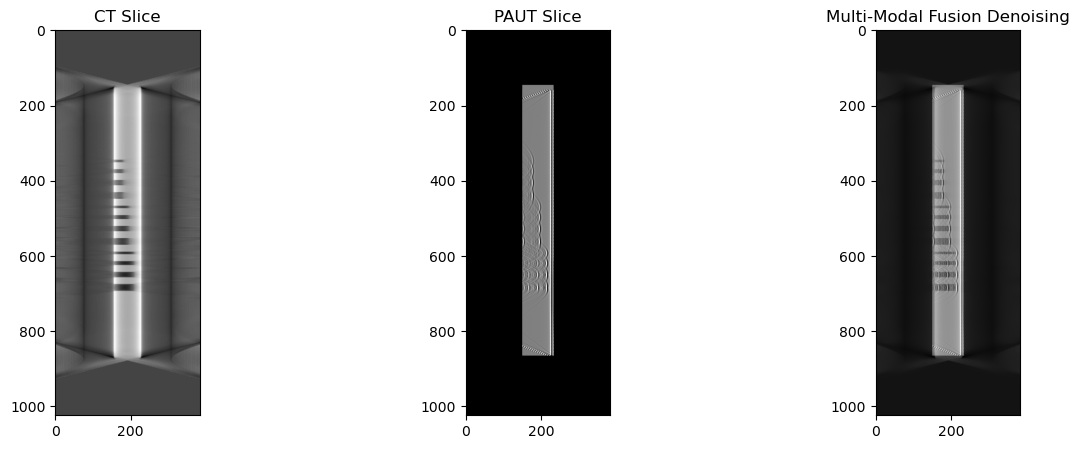

In [9]:
import SimpleITK as sitk
import numpy as np
import pywt
import matplotlib.pyplot as plt

def load_image(file_path):
    """Load a SimpleITK image from file."""
    return sitk.ReadImage(file_path)

def normalize_image(image):
    """Normalize image intensities to range [0,1]."""
    array = sitk.GetArrayFromImage(image)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return sitk.GetImageFromArray(array)

def cast_to_int(image, pixel_type=sitk.sitkUInt16):
    """Cast image to integer type (UInt16) for compatibility with Mask operations."""
    return sitk.Cast(image, pixel_type)

def extract_middle_slice(image):
    """
    Extract the middle slice from a 3D image using SimpleITK's ExtractImageFilter.
    This returns a 2D image.
    """
    size = list(image.GetSize())
    index = [0, 0, size[2] // 2]
    # Set the size for the extraction: full in x and y, but only 0 in the z-direction.
    size[2] = 0  
    extractor = sitk.ExtractImageFilter()
    extractor.SetSize(size)
    extractor.SetIndex(index)
    return extractor.Execute(image)

# --- Joint Bilateral Filtering ---
def joint_bilateral_filter(ct_image, paut_image, sigma_color=0.05, sigma_space=10):
    """Apply joint bilateral filtering using PAUT as guidance."""
    bilateral_filter = sitk.BilateralImageFilter()
    bilateral_filter.SetDomainSigma(sigma_space)
    bilateral_filter.SetRangeSigma(sigma_color)
    return bilateral_filter.Execute(ct_image)


# --- Multi-Modal Noise Reduction via Fusion ---
def multimodal_fusion_denoising(ct_image, paut_image):
    """Apply wavelet-based noise reduction by fusing PAUT guidance."""
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)
    
    coeffs_ct = pywt.dwtn(ct_array, 'haar')
    coeffs_paut = pywt.dwtn(paut_array, 'haar')
    fused_coeffs = {key: (coeffs_ct[key] + coeffs_paut[key]) / 2 for key in coeffs_ct.keys()}
    denoised_array = pywt.idwtn(fused_coeffs, 'haar')
    return sitk.GetImageFromArray(denoised_array)

# --- Display Function ---
def display_images(ct, paut, filtered, title='Filtered CT'):
    """Display CT, PAUT, and filtered images (2D slices)."""
    ct_array = sitk.GetArrayFromImage(ct)
    paut_array = sitk.GetArrayFromImage(paut)
    filtered_array = sitk.GetArrayFromImage(filtered)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(ct_array, cmap='gray')
    plt.title('CT Slice')
    plt.subplot(1,3,2)
    plt.imshow(paut_array, cmap='gray')
    plt.title('PAUT Slice')
    plt.subplot(1,3,3)
    plt.imshow(filtered_array, cmap='gray')
    plt.title(title)
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # Assume CT_data and resampled_paut are previously loaded 3D images.
    
    # Normalize full volumes
    ct_normalized = normalize_image(CT_data)
    paut_normalized = normalize_image(resampled_paut)
    
    # Extract middle slice from each volume
    ct_slice = extract_middle_slice(ct_normalized)
    paut_slice = extract_middle_slice(paut_normalized)
    
    # Apply different denoising techniques on the 2D slices
    fusion_filtered = multimodal_fusion_denoising(bilateral_filtered, paut_slice)
    bilateral_filtered = joint_bilateral_filter(ct_slice, paut_slice)


    # Display results
    display_images(ct_slice, paut_slice, bilateral_filtered, title='Joint Bilateral Filtering')
    display_images(ct_slice, paut_slice, fusion_filtered, title='Multi-Modal Fusion Denoising')


In [ ]:
import SimpleITK as sitk
import numpy as np
import pywt
import matplotlib.pyplot as plt

def load_image(file_path):
    """Load a SimpleITK image from file."""
    return sitk.ReadImage(file_path)

def normalize_image(image):
    """Normalize image intensities to range [0,1]."""
    array = sitk.GetArrayFromImage(image)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return sitk.GetImageFromArray(array)

def cast_to_int(image, pixel_type=sitk.sitkUInt16):
    """Cast image to integer type (UInt16) for compatibility with Mask operations."""
    return sitk.Cast(image, pixel_type)

# --- Joint Bilateral Filtering ---
def joint_bilateral_filter(ct_image, paut_image, sigma_color=0.1, sigma_space=5):
    """Apply joint bilateral filtering using PAUT as guidance."""
    bilateral_filter = sitk.BilateralImageFilter()
    bilateral_filter.SetDomainSigma(sigma_space)
    bilateral_filter.SetRangeSigma(sigma_color)
    return bilateral_filter.Execute(ct_image)

# --- Anisotropic Diffusion with PAUT Edge Guidance ---
def anisotropic_diffusion(ct_image, paut_image, time_step=0.125, iterations=10, conductance=1.0):
    """Apply anisotropic diffusion with PAUT edge guidance."""
    paut_edges = sitk.CannyEdgeDetection(paut_image, lowerThreshold=0.1, upperThreshold=0.3)
    diffused_ct = sitk.CurvatureAnisotropicDiffusion(ct_image, timeStep=time_step, conductanceParameter=conductance, numberOfIterations=iterations)
    return sitk.Mask(cast_to_int(diffused_ct), cast_to_int(paut_edges))

# --- Selective Filtering Based on PAUT Segmentation ---
def selective_filtering(ct_image, paut_image, filter_size=3):
    """Denoise CT while preserving PAUT-indicated defect regions."""
    paut_mask = sitk.BinaryThreshold(paut_image, lowerThreshold=1, upperThreshold=100.0)
    smoothed_ct = sitk.Median(ct_image, [filter_size] * 3)
    return sitk.Mask(cast_to_int(ct_image), cast_to_int(paut_mask)) + sitk.Mask(cast_to_int(smoothed_ct), sitk.Not(cast_to_int(paut_mask)))

# --- Multi-Modal Noise Reduction via Fusion ---
def multimodal_fusion_denoising(ct_image, paut_image):
    """Apply wavelet-based noise reduction by fusing PAUT guidance."""
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)
    
    coeffs_ct = pywt.dwtn(ct_array, 'haar')
    coeffs_paut = pywt.dwtn(paut_array, 'haar')
    fused_coeffs = {key: (coeffs_ct[key] + coeffs_paut[key]) / 2 for key in coeffs_ct.keys()}
    denoised_array = pywt.idwtn(fused_coeffs, 'haar')
    return sitk.GetImageFromArray(denoised_array)

# --- Display Function ---
def display_images(ct, paut, filtered, title='Filtered CT'):
    """Display CT, PAUT, and filtered images."""
    ct_array = sitk.GetArrayFromImage(ct)[ct.GetSize()[2]//2]
    paut_array = sitk.GetArrayFromImage(paut)[paut.GetSize()[2]//2]
    filtered_array = sitk.GetArrayFromImage(filtered)[filtered.GetSize()[2]//2]
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(ct_array, cmap='gray')
    plt.title('CT Image')
    plt.subplot(1,3,2)
    plt.imshow(paut_array, cmap='gray')
    plt.title('PAUT Image')
    plt.subplot(1,3,3)
    plt.imshow(filtered_array, cmap='gray')
    plt.title(title)
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # Normalize images
    ct_image = normalize_image(CT_data)
    paut_image = normalize_image(resampled_paut)
    
    # Apply different denoising techniques
    bilateral_filtered = joint_bilateral_filter(ct_image, paut_image)
    anisotropic_filtered = anisotropic_diffusion(ct_image, paut_image)
    selective_filtered = selective_filtering(ct_image, paut_image)
    fusion_filtered = multimodal_fusion_denoising(ct_image, paut_image)
    
    # Display results
    display_images(ct_image, paut_image, bilateral_filtered, title='Joint Bilateral Filtering')
    display_images(ct_image, paut_image, anisotropic_filtered, title='Anisotropic Diffusion')
    display_images(ct_image, paut_image, selective_filtered, title='Selective Filtering')
    display_images(ct_image, paut_image, fusion_filtered, title='Multi-Modal Fusion Denoising')
